# Setting up the modules 

In [1]:
# common libraries
import sys, glob, random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# analysis related modules
from scipy.stats import entropy, spearmanr
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold, GroupKFold
from sklearn.ensemble import RandomForestRegressor
from collections import Counter

In [3]:
from utils.utils import ci, rocauc, rmse

Using TensorFlow backend.


In [4]:
# some option settings for Jupyter notebook and TF
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_colwidth', -1)

# import dataset 

In [24]:
df_contexts = pd.read_pickle('dataset/predicting_contextual_informativeness-master/kapelner_context_filtered.pickle')

In [25]:
df_contexts.shape # row counts from the original paper: 67833

(67831, 624)

In [26]:
df_contexts.tail()

,context_id,context,target_word,band,mean_rating,inappropriate_count,collocation_1_10,collocation_11_20,collocation_21_50,collocation_51_100,...,AWL Sublist 6 Normed,AWL Sublist 7 Normed,AWL Sublist 8 Normed,AWL Sublist 9 Normed,AWL Sublist 10 Normed,All AFL Normed,Core AFL Normed,Spoken AFL Normed,Written AFL Normed,dataset
67826,4120489,"... If the patient is well motivated and given lifelong support, the weight loss is usually permanent. Furthermore, improvement of co-morbid conditions is also well-documented. That said, whether bariatric treatment for morbid obesity is a viable treatment option for more than a small minority of the obese population is open to doubt.",morbid,3,1.90,0,3.0,0.0,0.0,1.0,...,0.028302,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,2
67827,4120507,"... He also believes that guns give their carriers a dangerously false sense of security, and he dislikes the bang they make. His resistance to interrogation is exceptional and he has managed to keep the ""suffix-nine"" designation indicating he is ""reliable under torture"". He has a morbid dislike of dogs, especially guard dogs.",morbid,3,2.33,1,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,2
67828,4120509,"gave a 5 star rating to the movie and noted that ""the beauty of the film lies in its ability to throw light on a morbid subject, compelling the viewer to fall back in love with life."" The review added that the audience would feel ""a Hrithik hangover that stays with you long after you have left the theatre.""",morbid,3,2.50,0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,2
67829,4120511,"... Their strictly tongue-in-cheek humour, often involving executions, murder, necrophilia, resurrections and other morbid topics can be spotted in song titles and album names as well as in their very own mascot - an animated skeleton called ""Ben Wrangle"", the name being a pun on the Swedish word ""benrangel"" which best translates into ""skellington"".",morbid,3,3.13,2,0.0,0.0,0.0,1.0,...,0.000000,0.028169,0.0,0.000000,0.0,0.014085,0.014085,0.0,0.0,2
67830,4120513,"... Gamers could only share IP addresses of known servers between themselves or post them on gaming websites. To solve this problem, a team of three programmers (consisting of Jack ""morbid"" Mathews, Tim Cook, and Joe Powell) formed Spy Software and created QSpy (or QuakeSpy). This allowed the listing and searching of Quake servers available across the internet.",morbid,3,1.70,0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.016129,0.0,0.000000,0.000000,0.0,0.0,2


In [27]:
mm_scaler = MinMaxScaler()
# info_scores = mm_scaler.fit_transform(df_contexts[['mean_rating']])
# info_scores = info_scores[:,0]
df_contexts['mm_mean_rating'] = mm_scaler.fit_transform(df_contexts[['mean_rating']])[:,0]

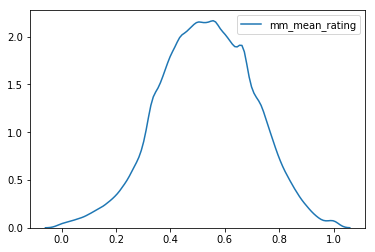

In [28]:
sns.kdeplot(df_contexts['mm_mean_rating'])

In [29]:
# pd.cut(df_contexts['mean_rating'], bins=[-float("inf"), 0, 0.5, 1, float("inf")]).value_counts(normalize=True)
df_contexts['mm_mean_rating'].describe()

count    67831.000000
mean     0.530754    
std      0.173382    
min      0.000000    
25%      0.406667    
50%      0.533333    
75%      0.666667    
max      1.000000    
Name: mm_mean_rating, dtype: float64

# Baseline model: RF regression

In [30]:
# setting the bootstrapping sample size for RF models: to follow the setting from the original Kapelner et al., paper
# https://stackoverflow.com/questions/44955555/how-can-i-set-sub-sample-size-in-random-forest-classifier-in-scikit-learn-espec
from sklearn.ensemble import forest

def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [31]:
gkf1 = GroupKFold(n_splits=10) ## target words

## RF regression 1: using the top-30 features 

In [13]:
col_features_top30 = ['similar_1_10', 'collocation_1_10', 'count:target-word1', 'politeness_component', 
                'Kuperman AoA AW', 'Kuperman AoA CW', 'count:word1-target-word2', 'MRC Meaningfulness CW', 
                'num_times_target_exact_match', 'num_acronyms', 'repeated_content_lemmas_pronoun', 'Polit_GI', 
                'prob:word1-target-word2', 'prob:target-word1', 'All AWL Normed',  'MRC Meaningfulness AW', 
                'affect_friends_and_family_component', 'Positive_EmoLex', 'count:target', 'num_times_target_stem_match', 
                'SUBTLEXus Freq AW', 'Econ_GI', 'prob:word1-word2-target', 'BNC Written Bigram Proportion',
                'Arousal_nwords', 'SUBTLEXus Range CW Log', 'BNC Written Trigram Proportion', 'disjunctions',
                'Arousal', 'Brown Freq CW Log']

In [14]:
set_rf_samples(10000)
gkf_split = gkf1.split(df_contexts['context'], groups=df_contexts['target_word'])

rfreg_top30_preds = []
rfreg_top30_score = []
for train_idx, test_idx in gkf_split:
    rfreg_top30 = RandomForestRegressor(random_state=0, n_estimators=500, n_jobs=-2)
    rfreg_top30.fit(df_contexts.iloc[train_idx][col_features_top30], df_contexts.iloc[train_idx]['mm_mean_rating'])
    
    rfreg_top30_preds.append({"preds":rfreg_top30.predict(df_contexts.iloc[test_idx][col_features_top30]),
                              "trues":df_contexts.iloc[test_idx]['mm_mean_rating'].values})
    rfreg_top30_score.append(rfreg_top30.score(df_contexts.iloc[test_idx][col_features_top30], df_contexts.iloc[test_idx]['mm_mean_rating']))

In [15]:
np.savez("kapelner_rfreg_top30_results.npy", preds=rfreg_top30_preds, score=rfreg_top30_score)

In [16]:
rfreg_top30_score

[0.18410580226206086,
 0.1842738487964217,
 0.16473658761187604,
 0.19121361590069363,
 0.19677687844382796,
 0.18664190514036383,
 0.1902408885789144,
 0.17124620341710062,
 0.19682058383731416,
 0.15195693372320596]

In [17]:
ci(rfreg_top30_score)

(0.1818013247711779, 0.1713044888434923, 0.19229816069886352)

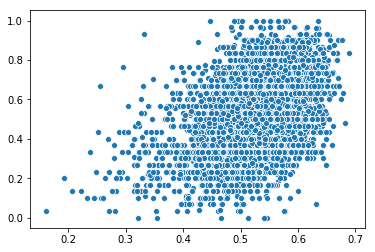

In [18]:
sns.scatterplot(rfreg_top30_preds[0]['preds'], rfreg_top30_preds[0]['trues'])

In [19]:
spearmanr(rfreg_top30_preds[0]['preds'], rfreg_top30_preds[0]['trues'])

SpearmanrResult(correlation=0.4156624089498486, pvalue=3.0338732231321177e-281)

In [20]:
# classification: top 20% sentences
rocauc(rfreg_top30_preds[0]['trues'], rfreg_top30_preds[0]['preds'], .80, "high")

0.6838936610365611

In [21]:
# classification: bottom 15% sentences
1-rocauc(rfreg_top30_preds[0]['trues'], rfreg_top30_preds[0]['preds'], .15, "low")

0.7501913769488584

In [22]:
# classification: 50:50
rocauc(rfreg_top30_preds[0]['trues'], rfreg_top30_preds[0]['preds'], .50, "high")

0.6999850822770468

## RF regression 2: using all features 

In [32]:
col_features_all = df_contexts.columns.tolist()[6:-2]

In [33]:
col_features_all

['collocation_1_10',
 'collocation_11_20',
 'collocation_21_50',
 'collocation_51_100',
 'collocation_101_199',
 'similar_1_10',
 'similar_11_20',
 'similar_21_50',
 'similar_51_100',
 'similar_101_199',
 'num_sentences',
 'num_words_quoted',
 'num_times_target_exact_match',
 'num_times_target_stem_match',
 'distance_from_center',
 'distance_from_edge',
 'num_isolated_letters',
 'num_years',
 'num_currency_signs',
 'num_punctuation',
 'num_commas',
 'num_exclamation_points',
 'num_semicolons',
 'num_colons',
 'num_periods',
 'num_ellipses',
 'num_pound_signs',
 'num_percent_signs',
 'num_times_inside_parenthetical',
 'num_parenthetical_statements',
 'num_quotes',
 'num_slashes',
 'num_proper_nouns',
 'num_words',
 'num_numbers',
 'num_acronyms',
 'count:target',
 'count:word1-target',
 'count:target-word1',
 'count:word1-word2-target',
 'count:word1-target-word2',
 'count:target-word1-word2',
 'count:word1-word2-word3-target',
 'count:word1-word2-target-word3',
 'count:word1-target-wor

In [34]:
len(col_features_all) # feature counts from the original paper: 615

617

In [36]:
reset_rf_samples()
set_rf_samples(10000)
gkf_split = gkf1.split(df_contexts['context'], groups=df_contexts['target_word'])

rfreg_all_preds = []
rfreg_all_score = []
for train_idx, test_idx in gkf_split:
    rfreg_all = RandomForestRegressor(random_state=0, n_estimators=500, n_jobs=-3)
    rfreg_all.fit(df_contexts.iloc[train_idx][col_features_all], df_contexts.iloc[train_idx]['mm_mean_rating'])
    
    rfreg_all_preds.append({"preds":rfreg_all.predict(df_contexts.iloc[test_idx][col_features_all]),
                            "trues":df_contexts.iloc[test_idx]['mm_mean_rating'].values})    
    rfreg_all_score.append(rfreg_all.score(df_contexts.iloc[test_idx][col_features_all], df_contexts.iloc[test_idx]['mm_mean_rating']))

In [37]:
np.savez("kapelner_rfreg_all_results.npy", preds=rfreg_all_preds, score=rfreg_all_score)

In [38]:
tt = np.load("kapelner_rfreg_all_results.npy.npz", allow_pickle=True)

In [39]:
rfreg_all_preds = tt['preds']
rfreg_all_score = tt['score']

In [40]:
rfreg_all_score

array([0.18592895, 0.18432299, 0.16748344, 0.18719804, 0.18980206,
       0.18688365, 0.18564987, 0.17200978, 0.18528638, 0.15156751])

In [41]:
ci(rfreg_all_score)

(0.1796132684027114, 0.17089620451073456, 0.18833033229468826)

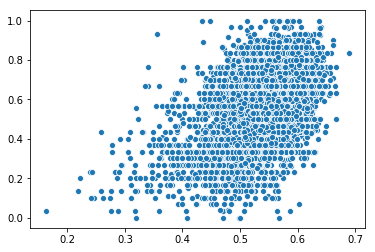

In [42]:
sns.scatterplot(rfreg_all_preds[0]['preds'], rfreg_all_preds[0]['trues'])

In [50]:
# spearmanr(rfreg_all_preds[0]['preds'], rfreg_all_preds[0]['trues'])
ci([r2_score(x['trues'], x['preds']) for x in rfreg_all_preds])

(0.17961326840271147, 0.17089620451073467, 0.18833033229468826)

In [43]:
# spearmanr(rfreg_all_preds[0]['preds'], rfreg_all_preds[0]['trues'])
ci([spearmanr(x['preds'], x['trues'])[0] for x in rfreg_all_preds])

(0.40936162366782725, 0.3958004284133775, 0.422922818922277)

In [44]:
# rocauc(rfreg_all_preds[0]['trues'], rfreg_all_preds[0]['preds'], .80, "high")
ci([rocauc(x['trues'], x['preds'], .80, "high") for x in rfreg_all_preds])

(0.6804147651798378, 0.668549406656556, 0.6922801237031195)

In [45]:
# 1-rocauc(rfreg_all_preds[0]['trues'], rfreg_all_preds[0]['preds'], .15, "low")
ci([1-rocauc(x['trues'], x['preds'], .20, "low") for x in rfreg_all_preds])

(0.735954498595637, 0.7290504625600464, 0.7428585346312276)

In [46]:
# rocauc(rfreg_all_preds[0]['trues'], rfreg_all_preds[0]['preds'], .50, "high")
ci([rocauc(x['trues'], x['preds'], .50, "high") for x in rfreg_all_preds])

(0.6979020746090342, 0.6912060464004222, 0.7045981028176462)

In [47]:
{"RMSE": ci([rmse(x['trues'], x['preds']) for x in rfreg_all_preds], digits=3),
 "20low":ci([1-rocauc(x['trues'], x['preds'], .20, "low") for x in rfreg_all_preds], digits=3),
 "50_50":ci([rocauc(x['trues'], x['preds'], .50, "high") for x in rfreg_all_preds], digits=3),
 "20_h": ci([rocauc(x['trues'], x['preds'], .80, "high") for x in rfreg_all_preds], digits=3),}

{'RMSE': (0.157, 0.154, 0.159),
 '20low': (0.736, 0.729, 0.743),
 '50_50': (0.698, 0.691, 0.705),
 '20_h': (0.68, 0.669, 0.692)}